# Snapp Support RAG

Here we will try to implement a RAG over the support documents from Snapp's support team

In [2]:
pip install --quiet ollama sentence-transformers protobuf tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --quiet langchain langchain-community chromadb

Note: you may need to restart the kernel to use updated packages.


# Generate Embeddings

First let's see if embeddings are already persisted locally. 

In [4]:
%%time
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings

ollamaBase = 'http://ollama-alibo-gpu-testing.apps.private.okd4.teh-2.snappcloud.io/'
embeddingModel = 'nomic-embed-text:v1.5'
#ollamaBase = 'http://localhost:11434'

embeddings = OllamaEmbeddings(model=embeddingModel,show_progress=True,base_url=ollamaBase)

vectorstore = Chroma('snappsupport',embeddings)
if vectorstore._collection.count() == 0:
    print("you need to follow the instructions in the next section and generate embeddings again")

print("vectorstore has {0} documents".format(vectorstore._collection.count()))

you need to follow the instructions in the next section and generate embeddings again
vectorstore has 0 documents
CPU times: user 4.74 ms, sys: 9.07 ms, total: 13.8 ms
Wall time: 22.2 ms


## Regenerate Embeddings


In [5]:
from langchain.document_loaders import BSHTMLLoader,DirectoryLoader
import os

path = './supportdocs'
loader = DirectoryLoader(path,glob="**/*.html",loader_cls=BSHTMLLoader)
docs = loader.load()
print(len(docs))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
203


In [6]:
print(list(map(lambda x: x.metadata['source'], docs[0:10])))

['supportdocs/انتخاب-از-میان-درخواست\u200cهای-سفر.html', 'supportdocs/دریافت-حق-کنسلی-به-صورت-خودکار-در-اپلیکیشن-راننده-اسنپ.html', 'supportdocs/مدارک-مورد-نیاز-برای-ثبت\u200cنام-در-اسنپ\u200cباکس.html', 'supportdocs/سفارش\u200cهای-رزرو-شده-در-اپلیکیشن-کاربران-راننده-اسنپ\u200cباکس.html', 'supportdocs/کاربران-حرفه\u200cای-اسنپ-چه-نکاتی-را-رعایت-می\u200cکنند؟.html', 'supportdocs/دسترسی-آسان-به-باشگاه-رانندگان-اسنپ-از-طریق-موبایل.html', 'supportdocs/مشاهده-مبدا-و-مقصد-مسافر-پیش-از-قبول-سفر.html', 'supportdocs/ویژگی-جدید-اپلیکیشن-راننده-اسنپ-نمایش-دلایل-مسدودی-حساب-کاربری.html', 'supportdocs/راهنمای-جامع-انتخاب-و-خرید-تایر-و-لاستیک-خودرو.html', 'supportdocs/صفر-تا-صد-نحوه-محاسبه-کمیسیون-اسنپ.html']


In [7]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=384)
splits = token_splitter.split_documents(docs)
print(len(splits))

/Users/qasim/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


1283


In [8]:
%%time
from langchain_community.embeddings import OllamaEmbeddings

embeddings = OllamaEmbeddings(model=embeddingModel,show_progress=True,base_url=ollamaBase)

CPU times: user 126 µs, sys: 157 µs, total: 283 µs
Wall time: 301 µs


In [9]:
%%time
from langchain.vectorstores import Chroma
vectorstore = Chroma.from_documents(collection_name='snappsupport',documents=splits, embedding=embeddings,persist_directory='./chromadb')

OllamaEmbeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [04:42<00:00,  4.54it/s]


CPU times: user 11.9 s, sys: 2.8 s, total: 14.7 s
Wall time: 4min 43s


# Retrieval

First we query chromadb directly to check if things are all right.

In [14]:
query = "پاداش-نقدی-بر-اساس-درآمد"
qembed = embeddings.embed_query(query)
results = vectorstore._collection.query(query_embeddings = qembed, n_results=3)
retrieved_documents = results['documents'][0]
print(retrieved_documents)

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

['صفر تا صد کارت خودرو ، نحوه استعلام و پیگیری کارت خودرو چیست [UNK] مدارک لازم برای دریافت کارت خودرواستعلام و پیگیری کارت خودرومفقود شدن یا استعلام کارت خودروی برگشتیمراحل صدور کارت خودرو المثنیمدارک لازم برای دریافت کارت خودروی المثنی', '##کزیزنجاناذربایجان شرقی ، اذربایجان غربی ، اردبیل ، البرز ، ایلام ، تهران ، قزوین ، کردستان ، کرمانشاه ، گیلان ، لرستان ، مازندران ، همدان ، سمنان ، قمسمنان اصفهان ، البرز ، تهران ، خراسان رضوی ، خراسان شمالی ، قم ، گلستان ، مازندران ، یزد ، همدان ، قزوین ، زنجان ، گیلان ، مرکزیسیستانوبلوچستان خراسان جنوبی ، کرمان ، هرمزگانفارساصفهان ، ایلام ، بوشهر ، چهارمحالوبختیاری ، خوزستان ، کرمان ، کهگیلویهوبویراحمد ، لرستان ، هرمزگان ، یزدقزویناذربایجان شرقی ، اذربایجان غربی ، البرز ، ایلام ، تهران ، زنجان ، کردستان ، کرمانشا', '، مرکزی ، اردبیل ، همدان ، یزد ، چهارمحالوبختیاریچهارمحالوبختیاریاصفهان ، ایلام ، بوشهر ، خوزستان ، فارس ، لرستان ، کهگیلویهوبویراحمد ، قم ، کردستان ، مرکزی ، همدان ، تهران ، قزوین ، البرز ، یزدخراسان جنوبیخراسان رضوی ، سیستانوبلوچست

In [15]:
import ollama

def newOllamaClient(baseURL):
    return ollama.Client(baseURL)

client = newOllamaClient(baseURL=ollamaBase)
retriever = vectorstore.as_retriever()

In [23]:
#llmModel = 'llama3'
llmModel = 'aya:8b'

systemPrompt = """شما یک دستیار متخصص مفید و مسلط به زبان فارسی هستید. کاربران شما رانندگانی هستند که درباره اسنپ ، یک شرکت سوارکاری،
سؤال می‌پرسند. سؤال کاربر و اطلاعات مربوطه از اسناد به عنوان زمینه به شما نشان داده می‌شود.
به سؤال کاربر فقط با استفاده از زمینه ارائه شده پاسخ دهید."""


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = client.chat(model=llmModel, options = { 'temperature': 0}, messages=[{'role': 'system', 'content': systemPrompt},{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    print("using from context",list(map(lambda x: x.metadata['source'],retrieved_docs)))
    return ollama_llm(question, formatted_context)

In [24]:
%%time
query = 'آخرین سفر من انجام نشده ولی تو لیست سفرها پایان خورده، چرا از من کمیسون کسر شده؟'
result = rag_chain(query)
print(result)

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


using from context ['supportdocs/معرفی-سرویس\u200cهای-پشتیبانی-برای-کاربران-راننده-اسنپ.html', 'supportdocs/اگر-درخواست\u200cهای-سفر-ارسال\u200cشده-اسنپ-را-قبول-نکنیم،-چه-اتفاقی-می\u200cافتد؟.html', 'supportdocs/صفر-تا-صد-کارت-خودرو،-نحوه-استعلام-و-پیگیری.html', 'supportdocs/سفرهای-بین\u200cاستانی؛-ویژگی\u200c-اپلیکیشن-کاربران-راننده-اسنپ.html']
متاسفم، اما من نمی‌توانم درخواست شما را پردازش کنم زیرا به نظر می‌رسد که بخشی از متن یا اطلاعات زمینه‌ای گم شده است. لطفاً سؤال خود را دوباره ارسال کنید و اطمینان حاصل کنید که تمام اطلاعات مربوطه را شامل می‌شود.
CPU times: user 28.9 ms, sys: 59.7 ms, total: 88.7 ms
Wall time: 15 s


In [26]:
query = 'چرا پاداش تاریخ 28 اردیبهشت رو برای من واریز نکردید؟.'
result = rag_chain(query)
print(result)

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


using from context ['supportdocs/کاربران-حرفه\u200cای-اسنپ-چه-نکاتی-را-رعایت-می\u200cکنند؟.html', 'supportdocs/معرفی-طرح-تشویقی-با-پاداش-نقدی-بر-اساس-درآمد.html', 'supportdocs/قدردانی-از-کاربر-راننده؛-ویژگی-اپلیکیشن-کاربران-راننده-اسنپ.html', 'supportdocs/راهنمای-درخواست\u200cهای-سفر-تلفنی-اسنپ-۱۵۵۱.html']
متاسفم، اما به نظر می‌رسد که اطلاعات کافی برای پاسخ دادن به سؤال شما وجود ندارد. لطفاً جزئیات بیشتری ارائه دهید یا سؤال خود را واضح‌تر مطرح کنید تا بتوانم به بهترین نحو به شما کمک کنم.


In [27]:
query = 'مسافر هزینه سفرو به من نداده، لطفاً رسیدگی کنید.'
result = rag_chain(query)
print(result)

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]


using from context ['supportdocs/نکات-مهم-رانندگی-در-جاده-و-سفر.html', 'supportdocs/صفر-تا-صد-استفاده-از-مسیریاب-در-سفرهای-اسنپی.html', 'supportdocs/مدال\u200cهای-افتخار-رانندگان-اسنپ؛-نمایش-کیفیت-عملکرد-کاربران-راننده.html', 'supportdocs/فرمول-درآمد-بالا-در-اسنپ.html']
متاسفم، اما به نظر می‌رسد که اطلاعات کافی برای پاسخ دادن به این درخواست در اختیار ندارم. لطفا جزئیات بیشتری ارائه دهید یا سؤال خود را واضح‌تر بیان کنید تا بتوانم به بهترین نحو به شما کمک کنم.


# Visualization


In [29]:
import chromadb
dbclient = chromadb.PersistentClient(path='./chromadb')
col = dbclient.get_collection('snappsupport')
print(col.count())

all_embeddings = col.get(include=['embeddings'])['embeddings']
print(len(all_embeddings))

1283
1283


In [30]:
%pip install --quiet umap-learn matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [31]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

reducer = umap.UMAP(random_state=0,transform_seed=0)
umap_transform = reducer.fit(all_embeddings)

/Users/qasim/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [32]:
def project_embeddings(embeddings, umap_transform):
    """project embeddings into a 2d space"""
    umap_embeddings = np.empty((len(embeddings),2))
    for i,embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


In [33]:
projected_all_embeddings = project_embeddings(all_embeddings,umap_transform)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [12:11<00:00,  1.75it/s]


(1.9600436329841613, 9.846918618679046, 4.867548608779908, 15.745867109298706)

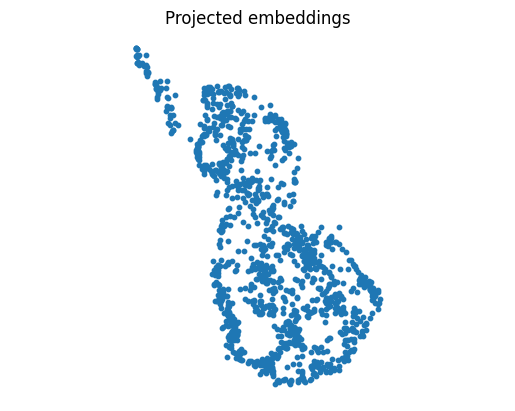

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_all_embeddings[:,0],projected_all_embeddings[:,1], s=10)

plt.gca().set_aspect('equal','datalim')
plt.title('Projected embeddings')
plt.axis('off')